In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [85]:


sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

from lib.gamma_sf_approx import gamma_sf_fast
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_midpoint2

from jax.scipy.stats.gamma import pdf as gamma_pdf
from jax.scipy.stats.gamma import logpdf as gamma_logpdf
from jax.scipy.special import logsumexp

from jax.scipy.stats.norm import logpdf as norm_logpdf

In [66]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [67]:
dist = 20
z = -500
rho = 0.0
zenith = 1.57
azimuth = 3.9264083

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [68]:
xvals = jnp.linspace(1.e-12, 10.0, 10000)

In [69]:
@jax.jit
def triple_gamma_linear(xvals, a, b, mix_probs):
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    xvals_e = jnp.expand_dims(xvals, axis=0)
    y = jnp.sum(mix_probs_e * jnp.clip(gamma_pdf(xvals_e, a_e, scale=1./b_e), min=0, max=None), axis=0)
    return y

In [70]:
triple_gamma_linear(xvals, gamma_a, gamma_b, mix_probs)

Array([0.00029564, 0.00031199, 0.00031907, ..., 0.04902819, 0.04902351,
       0.04901883], dtype=float64)

In [71]:
@jax.jit
def triple_gamma_log(xvals, a, b, mix_probs):
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    xvals_e = jnp.expand_dims(xvals, axis=0)
    log_y = logsumexp(gamma_logpdf(xvals_e, a_e, scale=1./b_e), 0, mix_probs_e)
    return jnp.exp(log_y)

In [72]:
triple_gamma_log(xvals, gamma_a, gamma_b, mix_probs)

Array([0.00029564, 0.00031199, 0.00031907, ..., 0.04902819, 0.04902351,
       0.04901883], dtype=float64)

In [73]:
%timeit triple_gamma_linear(xvals, gamma_a, gamma_b, mix_probs)

33.3 μs ± 1.74 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [74]:
%timeit triple_gamma_log(xvals, gamma_a, gamma_b, mix_probs)

35.4 μs ± 1.58 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
@jax.jit
def triple_gamma_sf_linear(xvals, a, b, mix_probs):
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    xvals_e = jnp.expand_dims(xvals, axis=0)
    y = jnp.sum(mix_probs_e * gamma_sf_fast(xvals_e, a_e, b_e), axis=0)
    return y

In [76]:
triple_gamma_sf_linear(xvals, gamma_a, gamma_b, mix_probs)

Array([1.        , 0.99999931, 0.99999862, ..., 0.65584829, 0.65579878,
       0.65574928], dtype=float64)

In [77]:
@jax.jit
def triple_gamma_sf_log(xvals, a, b, mix_probs):
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    xvals_e = jnp.expand_dims(xvals, axis=0)
    log_y = logsumexp(jnp.log(gamma_sf_fast(xvals_e, a_e, b_e)), 0, mix_probs_e)  ## careful about possible 0 in gamma_sf_fast
    return jnp.exp(log_y)

In [78]:
triple_gamma_sf_log(xvals, gamma_a, gamma_b, mix_probs)

Array([1.        , 0.99999931, 0.99999862, ..., 0.65584829, 0.65579878,
       0.65574928], dtype=float64)

In [79]:
%timeit triple_gamma_sf_linear(xvals, gamma_a, gamma_b, mix_probs)

43.7 μs ± 67.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [80]:
%timeit triple_gamma_sf_log(xvals, gamma_a, gamma_b, mix_probs)

52.6 μs ± 40.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [82]:
x0 = 5
n = 20

In [84]:
print(c_multi_gamma_mpe_prob_midpoint2(x0, mix_probs, gamma_a, gamma_b, n, 3.0))

0.10111555864720452


In [114]:
def c_multi_gamma_mpe_prob_midpoint3(x, mix_probs, a, b, n, sigma=3.0):
    """
    Q < 30
    """
    nmax = 10
    nint1 = 10
    nint2 = 15
    nint3 = 35
    #eps = 1.e-12
    eps = 1.e-6

    x0 = eps
    x_m0 = 0.01
    xvals0 = jnp.linspace(x0, x_m0, 10)

    x_m1 = 0.05
    xvals1 = jnp.linspace(x_m0, x_m1, 10)

    x_m2 = 0.25
    xvals2 = jnp.linspace(x_m1, x_m2, 10)

    x_m25 = 0.75
    xvals25 = jnp.linspace(x_m2, x_m25, 10)

    x_m3 = 2.5
    xvals3 = jnp.linspace(x_m25, x_m3, 10)

    x_m4 = 8.0
    xvals4 = jnp.linspace(x_m3, x_m4, 20)

    xmin = jnp.max(jnp.array([1.5 * eps, x - 10 * sigma]))
    xmax = jnp.max(jnp.array([xmin+1.5*eps, x + 10 * sigma]))
    xvals_x = jnp.linspace(xmin, xmax, 101)
    xvals = jnp.sort(jnp.concatenate([xvals0, xvals1, xvals2, xvals25, xvals3, xvals4, xvals_x]))

    dx = xvals[1:]-xvals[:-1]

    xvals = 0.5*(xvals[:-1]+xvals[1:])
    log_n_pdf = norm_logpdf(xvals, loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    log_pdfs = logsumexp(gamma_logpdf(xvals_e, a_e, scale=1./b_e), 0, mix_probs_e)
    log_sfs = logsumexp(jnp.log(gamma_sf_fast(xvals_e, a_e, b_e)), 0, mix_probs_e)

    return logsumexp(log_n_pdf + log_pdfs + (n-1) * log_sfs, 0, dx * n)

In [115]:
print(c_multi_gamma_mpe_prob_midpoint3(x0, mix_probs, gamma_a, gamma_b, n, 3.0))

-2.2914912711541398


In [116]:
f1 = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint2, (0, None, None, None, None, None), 0))

In [117]:
f2 = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint3, (0, None, None, None, None, None), 0))

In [118]:
xvals = np.linspace(-300, 100, 1000)
probs1 = f1(xvals, mix_probs, gamma_a, gamma_b, 1000, 3.0)
probs2 = f2(xvals, mix_probs, gamma_a, gamma_b, 1000, 3.0)

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


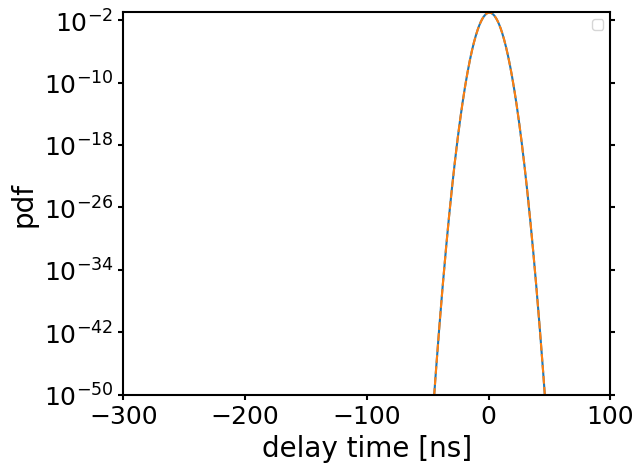

In [119]:
fig, ax = plt.subplots()
plt.plot(xvals, probs1)
plt.plot(xvals, jnp.exp(probs2), linestyle='dashed')
plot_args = {'xlim':[-300, 100],
                     'ylim':[0.0, 1.2 * np.amax(probs1)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.yscale('log')
plt.ylim(ymin=1.e-50)
plt.show()

In [120]:
probs1

Array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [121]:
probs2

Array([-5.00645317e+03, -4.99311386e+03, -4.97979237e+03, -4.96648868e+03,
       -4.95320280e+03, -4.93993474e+03, -4.92668448e+03, -4.91345204e+03,
       -4.90023741e+03, -4.88704059e+03, -4.87386158e+03, -4.86070038e+03,
       -4.84755699e+03, -4.83443142e+03, -4.82132365e+03, -4.80823370e+03,
       -4.79516156e+03, -4.78210722e+03, -4.76907070e+03, -4.75605200e+03,
       -4.74305110e+03, -4.73006801e+03, -4.71710274e+03, -4.70415527e+03,
       -4.69122562e+03, -4.67831378e+03, -4.66541974e+03, -4.65254352e+03,
       -4.63968512e+03, -4.62684452e+03, -4.61402173e+03, -4.60121676e+03,
       -4.58842959e+03, -4.57566024e+03, -4.56290869e+03, -4.55017496e+03,
       -4.53745904e+03, -4.52476093e+03, -4.51208063e+03, -4.49941815e+03,
       -4.48677347e+03, -4.47414660e+03, -4.46153755e+03, -4.44894631e+03,
       -4.43637287e+03, -4.42381725e+03, -4.41127944e+03, -4.39875944e+03,
       -4.38625725e+03, -4.37377287e+03, -4.36130631e+03, -4.34885755e+03,
       -4.33642661e+03, -

In [111]:
jax.scipy.stats.norm.logpdf(-35, 0, 1)

Array(-613.41893853, dtype=float64, weak_type=True)